# Part 3: Experiment and optimize the RAG application

- GitHub repository: https://github.com/Disiok/ai-engineer-workshop/
- Ray documentation: https://docs.ray.io/
- LlamaIndex documentation: https://gpt-index.readthedocs.io/en/stable/

In this tutorial, we will focus on improving our RAG application by experimenting with different configurations and optimizing individual components as well how they are composed together in the overall pipeline.
This builds on top of the evaluation functions that we've setup in the previous part of the notebook (i.e. to evaluate the retrieval and end-to-end performance of the RAG system).

Here, we will explore 4 specific strategies:
1. searching for optimal configurations for standard components
2. using second-stage re-rankers
3. using different representations for retrieval vs. generation
4. fine-tuning embedding models

In [25]:
import os

# os.environ["OPENAI_API_KEY"] = ...

os.environ["DB_CONNECTION_STRING"] = "dbname=postgres user=postgres host=localhost password=postgres"

In [2]:
import ray

# Credentials
ray.init(runtime_env={
    "env_vars": {
        "OPENAI_API_KEY": os.environ["OPENAI_API_KEY"], 
        "DB_CONNECTION_STRING": os.environ["DB_CONNECTION_STRING"],
    },
})

2023-10-08 16:35:57,171	INFO worker.py:1642 -- Started a local Ray instance.


Python version:,3.11.4
Ray version:,2.7.0


In [3]:
import nest_asyncio

nest_asyncio.apply()

## Strategy 1: Search for optimal configuration for standard components

With our evaluator set, we're ready to start experimenting with the various components in our LLM application. While we could perform this as a large [tuning experiment](https://docs.ray.io/en/latest/tune/index.html), where we can search across promising combintion of values/decisions, we're going to evaluation one decision at a time and fix the best value for the next experiment.

**Note**: this approach is slightly biased because many of our decisions are not indepedent (ex. `chunk_size` and `top_k` should ideally be evaluated across many combinations of values).

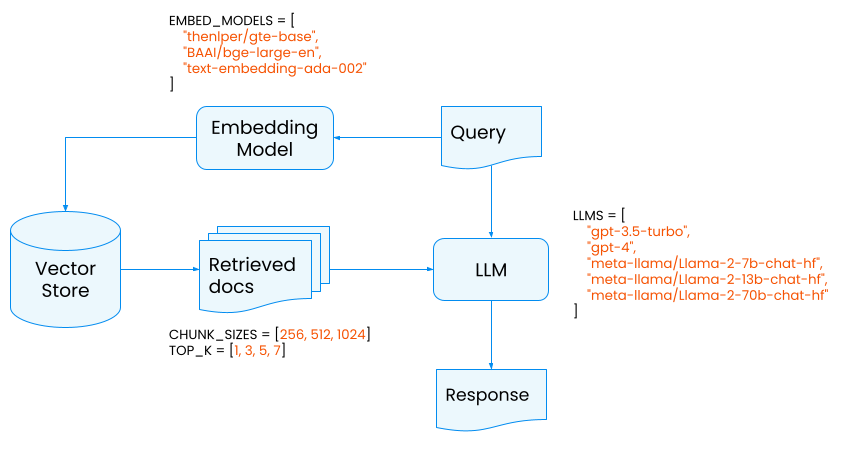

#### Utilities

Before we get started with our experiments, we're going to define some utility functions that we'll use to easily run and evaluate retrieval and response generation using different experiment configurations. This will leverage some of the code we've written in previous notebooks on building an index (part 1), and evaluating retriever and query engines (part 2).

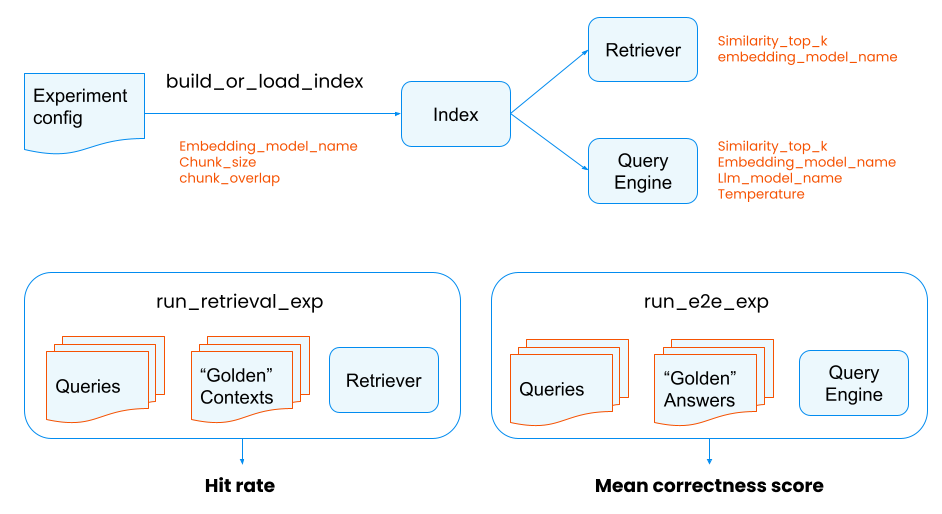

In [21]:
import os
from pathlib import Path

# Paths
ROOT_DIR = Path(os.getcwd()).parent
EXPERIMENTS_DIR = Path(ROOT_DIR, "experiments")

DATA_DIR = Path(ROOT_DIR, 'datasets')
DOCS_PATH = Path(DATA_DIR, "docs.ray.io/en/master/")
SQL_DUMP_DIR = Path(DATA_DIR, "sql_dumps")
SQL_DUMP_DIR.mkdir(parents=True, exist_ok=True)

In [22]:
import subprocess
from data import build_index

def execute_bash(command):
    results = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    return results

def build_or_load_index(docs_path, embedding_model_name, chunk_size, chunk_overlap):
    # Drop current Vector DB and prepare for new one
    execute_bash(f'docker exec -u postgres ai-engineer-workshop-postgres-1 psql -c "DROP TABLE data_document;"')
    SQL_DUMP_FP = Path(SQL_DUMP_DIR, f"{embedding_model_name.split('/')[-1]}_{chunk_size}_{chunk_overlap}.sql")
    
    # Vector DB
    if SQL_DUMP_FP.exists():  # Load from SQL dump
        print('Loading from SQL dump')
        execute_bash(f'docker exec -u postgres ai-engineer-workshop-postgres-1 psql < {SQL_DUMP_FP}')
    else:  
        print('Creating new index')
        build_index(docs_path, embedding_model_name, chunk_size, chunk_overlap)
        
        print('Saving to SQL dump')
        execute_bash(f"docker exec -u postgres ai-engineer-workshop-postgres-1 pg_dump -c > {SQL_DUMP_FP}")

In [23]:
import json 

from utils import get_retriever, get_query_engine
from eval import evaluate_retrieval, evaluate_e2e, get_hit_rate, get_mean_score
from pprint import pprint

DEFAULT_EXP_CONFIG = {
    'embedding_model_name': "text-embedding-ada-002",
    'chunk_size': 1024,
    'chunk_overlap': 50,
    'similarity_top_k': 5,
    'llm_model_name': 'gpt-3.5-turbo',
    'temperature': 0.1,
}

def run_retrieval_exp(
    docs_path,
    exp_config={},
    verbose=False,
):
    run_exp_config = DEFAULT_EXP_CONFIG.copy()
    run_exp_config.update(exp_config)
    if verbose:
        pprint(run_exp_config)
    
    build_or_load_index( 
        docs_path=docs_path,
        embedding_model_name=run_exp_config['embedding_model_name'],
        chunk_size=run_exp_config['chunk_size'],
        chunk_overlap=run_exp_config['chunk_overlap'],
    )
    retriever = get_retriever(
        similarity_top_k=run_exp_config['similarity_top_k'],
        embedding_model_name=run_exp_config['embedding_model_name'],
    )
    
    golden_dataset_path = Path("../datasets/eval-dataset-v1.jsonl")
    with open(golden_dataset_path, "r") as f:
        golden_dataset = [json.loads(item) for item in list(f)]

    queries = [item['question'] for item in golden_dataset]
    golden_sources = [item['source'] for item in golden_dataset]
    
    results = evaluate_retrieval(retriever, queries, golden_sources)
    return results

def run_e2e_exp(
    docs_path,
    exp_config={},
    verbose=False, 
):
    run_exp_config = DEFAULT_EXP_CONFIG.copy()
    run_exp_config.update(exp_config)
    if verbose:
        pprint(run_exp_config)

    build_or_load_index( 
        docs_path=docs_path,
        embedding_model_name=run_exp_config['embedding_model_name'],
        chunk_size=run_exp_config['chunk_size'],
        chunk_overlap=run_exp_config['chunk_overlap'],
    )
    
    query_engine = get_query_engine(
        similarity_top_k=run_exp_config['similarity_top_k'],
        embedding_model_name=run_exp_config['embedding_model_name'],
        llm_model_name=run_exp_config['llm_model_name'],
        temperature=run_exp_config['temperature'],
    )
    
    with open("../datasets/golden-responses.json", "r") as file:
        golden_dataset = json.load(file)
    
    queries = [item['question'] for item in golden_dataset]
    golden_response = [item['response'] for item in golden_dataset]
    golden_sources = [item['source'] for item in golden_dataset]

    results = evaluate_e2e(query_engine, queries, golden_response, verbose=True)
    return results

### Chunk Size 

Next, we'll access various chunk sizes. Smaller chunks (but not too small!) are able to encapsulate atomic concepts which yields more precise retrieval. While larger chunks may be more noisy. Popular strategies include using small chunks but retrieving a bit of the [surrounding chunks](https://gpt-index.readthedocs.io/en/latest/end_to_end_tutorials/dev_practices/production_rag.html#decoupling-chunks-used-for-retrieval-vs-chunks-used-for-synthesis) around it (since it may have relevnat info) or store [mulitple embeddings](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) per document (ex. summary embedding per document). 

In [24]:
CHUNK_SIZES = [
    256,
    512, 
    1024,
]

In [20]:
for chunk_size in CHUNK_SIZES:
    print('Running chunk size experiment: ', chunk_size)
    retrieval_results = run_retrieval_exp(DOCS_PATH, {'chunk_size': chunk_size})
    hit_rate = get_hit_rate(retrieval_results)
    print('Retrieval hit rate: ', hit_rate)
    
    e2e_results = run_e2e_exp(DOCS_PATH, {'chunk_size': chunk_size})
    mean_score = get_mean_score(e2e_results)
    print('End to end mean score: ', mean_score)

Running chunk size experiment:  256
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:23<00:00,  7.66it/s]


Retrieval hit rate:  0.384180790960452
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:36<00:00,  3.69s/it]


Running eval


100%|██████████| 10/10 [00:59<00:00,  5.95s/it]


End to end mean score:  4.25
Running chunk size experiment:  512
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:10<00:00, 16.54it/s]


Retrieval hit rate:  0.4745762711864407
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


Running eval


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


End to end mean score:  4.3
Running chunk size experiment:  1024
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 21.78it/s]


Retrieval hit rate:  0.519774011299435
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:34<00:00,  3.45s/it]


Running eval


100%|██████████| 10/10 [00:58<00:00,  5.86s/it]

End to end mean score:  4.2


Seem that a larger chunk size improves retrieval, but the end-to-end generation performance plateaus at 512 (too much context might be too noisy).

**Note**: If we were to use larger chunk sizes, keep in mind that [most](https://huggingface.co/spaces/mteb/leaderboard) open source embedding models have a maximum sequence length of 512 sub-word tokens. This means that if our chunk contains more than 512 sub-word tokens, the embedding wouldn't account for it anyway (unless we finetune our embedding model to have longer sequence lengths).

### Top K

**Note**: Keep in mind that the `chunk_size` you chose multiplied by the `top_k` below fits inside the LLM's context length. We're experimenting with the chunk size and number of chunks as if they were indepdent variables but they area heavily related. Especially since all of our LLMs have a finite maximum context length. So ideally, we would tune for a combination of `chunk_size` * `top_k`.

In [39]:
TOP_K = [1, 3, 5, 7]

In [40]:
for top_k in TOP_K:
    print('Running top k experiment: ', top_k)
    retrieval_results = run_retrieval_exp(DOCS_PATH, {'similarity_top_k': top_k})
    hit_rate = get_hit_rate(retrieval_results)
    print('Retrieval hit rate: ', hit_rate)
    
    e2e_results = run_e2e_exp(DOCS_PATH, {'similarity_top_k': top_k})
    mean_score = get_mean_score(e2e_results)
    print('End to end mean score: ', mean_score)

Running top k experiment:  1
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 21.98it/s]


Retrieval hit rate:  0.1694915254237288
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


Running eval


100%|██████████| 10/10 [00:59<00:00,  5.96s/it]


End to end mean score:  3.9
Running top k experiment:  3
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 21.29it/s]


Retrieval hit rate:  0.3615819209039548
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


Running eval


100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


End to end mean score:  4.0
Running top k experiment:  5
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 21.29it/s]


Retrieval hit rate:  0.519774011299435
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


Running eval


100%|██████████| 10/10 [00:49<00:00,  4.93s/it]


End to end mean score:  4.3
Running top k experiment:  7
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 20.80it/s]


Retrieval hit rate:  0.615819209039548
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


Running eval


100%|██████████| 10/10 [00:53<00:00,  5.36s/it]

End to end mean score:  4.4


Increasing our number of chunks improves our retrieval and quality scores. But it also seems that the benefit of increasing the number of chunks is starting to taper off.

### Embedding Model

So far, we've used [`thenlper/gte-base`](https://huggingface.co/thenlper/gte-base) as our embedding model because it's a relatively small (0.22 GB) and performant option. But now, let's explore other popular options such the current leader on the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard), [`BAAI/bge-large-en`](https://huggingface.co/BAAI/bge-large-en) (1.34 GB), and OpenAI's [`text-embedding-ada-002`](https://openai.com/blog/new-and-improved-embedding-model).

In [23]:
EMBED_MODELS = [
    "thenlper/gte-base", 
    "BAAI/bge-large-en", 
    "text-embedding-ada-002"
]

In [24]:
for embed_model in EMBED_MODELS:
    print('Running embedding model experiment: ', embed_model)
    retrieval_results = run_retrieval_exp(DOCS_PATH, {'embedding_model_name': embed_model})
    hit_rate = get_hit_rate(retrieval_results)
    print('Retrieval hit rate: ', hit_rate)
    
    e2e_results = run_e2e_exp(DOCS_PATH, {'embedding_model_name': embed_model})
    mean_score = get_mean_score(e2e_results)
    print('End to end mean score: ', mean_score)

Running embedding model experiment:  thenlper/gte-base
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 21.09it/s]


Retrieval hit rate:  0.519774011299435
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:42<00:00,  4.27s/it]


Running eval


100%|██████████| 10/10 [01:01<00:00,  6.16s/it]


End to end mean score:  4.25
Running embedding model experiment:  BAAI/bge-large-en
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:11<00:00, 15.98it/s]


Retrieval hit rate:  0.22033898305084745
Loading from SQL dump
Running inference


 10%|█         | 1/10 [00:05<00:50,  5.59s/it]

(autoscaler +16m9s) [autoscaler] Downscaling node i-0c0d2d21fc3d066bf due to node idle termination.
(autoscaler +16m10s) [autoscaler] Cluster resized to {16 CPU, 1 GPU}.


100%|██████████| 10/10 [00:40<00:00,  4.03s/it]


Running eval


100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


End to end mean score:  4.15
Running embedding model experiment:  text-embedding-ada-002
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:48<00:00,  3.69it/s]


Retrieval hit rate:  0.384180790960452
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


Running eval


100%|██████████| 10/10 [00:59<00:00,  5.96s/it]

End to end mean score:  3.85


This is an interesting outcome because the #1 (`BAAI/bge-large-en`) on the current leaderboard isn't necessarily the best for our specific task. Using the smaller `thenlper/gte-base` produced the best retrieval and quality scores in our experiments.

### LLMs

We're now going to use the best configurations from above to evaluate different choices for the main LLM.

**Note**:
- We've been using a specific LLM so far to decide on the configuration so that specific LLM's performance here will be a bit biased.
- This list is not exhaustive and even for the LLMs we use, there are versions with longer context windows available.

In [43]:
LLMS = [
    "gpt-3.5-turbo",
    "gpt-4",
    "meta-llama/Llama-2-7b-chat-hf", 
    "meta-llama/Llama-2-13b-chat-hf", 
    "meta-llama/Llama-2-70b-chat-hf"
]

In [44]:
for llm in LLMS:
    print('Running LLM experiment: ', llm)
    retrieval_results = run_retrieval_exp(DOCS_PATH, {'llm_model_name': llm})
    hit_rate = get_hit_rate(retrieval_results)
    print('Retrieval hit rate: ', hit_rate)
    
    e2e_results = run_e2e_exp(DOCS_PATH, {'llm_model_name': llm})
    mean_score = get_mean_score(e2e_results)
    print('End to end mean score: ', mean_score)

Running LLM experiment:  gpt-3.5-turbo
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 20.50it/s]


Retrieval hit rate:  0.519774011299435
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:38<00:00,  3.86s/it]


Running eval


100%|██████████| 10/10 [00:58<00:00,  5.85s/it]


End to end mean score:  4.25
Running LLM experiment:  gpt-4
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 21.20it/s]


Retrieval hit rate:  0.519774011299435
Loading from SQL dump
Running inference


100%|██████████| 10/10 [01:51<00:00, 11.17s/it]


Running eval


100%|██████████| 10/10 [00:59<00:00,  5.96s/it]


End to end mean score:  4.85
Running LLM experiment:  meta-llama/Llama-2-7b-chat-hf
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 21.14it/s]


Retrieval hit rate:  0.519774011299435
Loading from SQL dump
Running inference


100%|██████████| 10/10 [01:11<00:00,  7.13s/it]


End to end mean score:  3.65
Running LLM experiment:  meta-llama/Llama-2-13b-chat-hf
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 20.95it/s]


Retrieval hit rate:  0.519774011299435
Loading from SQL dump
Running inference


100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


Running eval


100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


End to end mean score:  3.9
Running LLM experiment:  meta-llama/Llama-2-70b-chat-hf
Loading from SQL dump
LLM is explicitly disabled. Using MockLLM.


100%|██████████| 177/177 [00:08<00:00, 20.77it/s]


Retrieval hit rate:  0.519774011299435
Loading from SQL dump
Running inference


100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


Running eval


100%|██████████| 10/10 [01:14<00:00,  7.41s/it]

End to end mean score:  4.4


We see that OpenAI models have the best performance, but `meta-llama/Llama-2-70b-chat-hf` is a strong contender with a score that surpasses `gpt-3.5-turbo`.  
Note that since we are using `gpt-4` as the evaluator, there's some known bias where it prefers OpenAI family of models.

**Note**: Some of our LLMs have much larger context lengths, ex. `gpt-4` is 8192 and `gpt-3.5-turbo-16k` is 16384. We could increase the number of chunks that we use for these since we saw that increasing `top_k` continued to improve the retrieval and quality scores. However, we will keep this value fixed for now since the performance started to taper off anyway and so we can compare these performances under the exact same configurations.

## Strategy 2: Use a second-stage reranker

As we've seen above, increasing the number of retrieved documents make it more likely for us to recover the "golden" context that we need to answer a user query. However, it also means that we need to feed the LLM more and potentially irrelvant context, this can increase latency and make it more likely to "distract" the LLM.

One strategy to mitigate this is to introduce a re-ranking stage to the retrieval pipeline. This way, we can first retrieve a high number of relevant nodes quickly (optimizing for recall), and then use an accurate ranking model to filter for the most relevant nodes (optimizing for precision).

This can improve retrieval and generation performance, without needing to feed more context into the LLM.

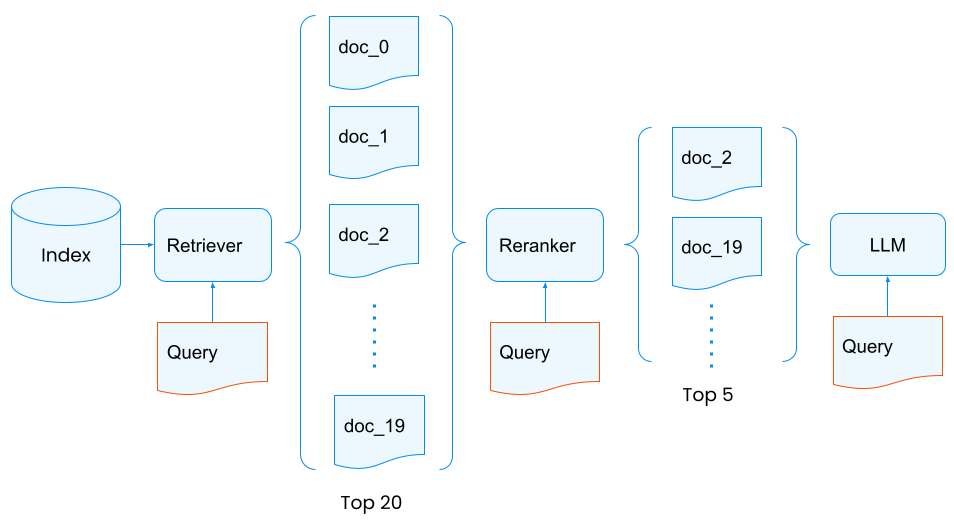

#### Load data

In [97]:
from pathlib import Path

DATASETS_DIRECTORY = Path("/efs/shared_storage/simon/datasets")

In [98]:
import json
from llama_index.schema import Document

def read_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def to_doc(entry_dict):
    return Document(text=entry_dict['text'], metadata={'source': entry_dict['source']}) 

def load_corpus(filename):
    sections = read_json(filename)
    docs = [to_doc(dict_) for dict_ in sections]
    return docs

In [99]:
docs = load_corpus(DATASETS_DIRECTORY / 'eval_full_corpus.json')

#### Build index

In [100]:
from langchain.embeddings import HuggingFaceEmbeddings
from llama_index import ServiceContext, VectorStoreIndex

service_context = ServiceContext.from_defaults(
    embed_model=HuggingFaceEmbeddings(
        model_name='thenlper/gte-base'
    ),
)

index = VectorStoreIndex.from_documents(
    docs, 
    service_context=service_context, 
    show_progress=True
)

Parsing documents into nodes:   0%|          | 0/8944 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/9537 [00:00<?, ?it/s]

#### Configure rerankers

In [145]:
from llama_index.indices.postprocessor import SentenceTransformerRerank, LLMRerank

st_reranker = SentenceTransformerRerank(
    top_n=5, model="cross-encoder/ms-marco-MiniLM-L-6-v2"
)

llm_reranker = LLMRerank(
    choice_batch_size=4, top_n=5,
)

#### Load evaluation data

In [127]:
golden_dataset_path = Path("../datasets/eval-dataset-v1.jsonl")
with open(golden_dataset_path, "r") as f:
    golden_dataset = [json.loads(item) for item in list(f)]

retrieval_queries = [item['question'] for item in golden_dataset]
golden_sources = [item['source'] for item in golden_dataset]

In [128]:
with open("../datasets/golden-responses.json", "r") as file:
    golden_dataset = json.load(file)

e2e_queries = [item['question'] for item in golden_dataset]
golden_response = [item['response'] for item in golden_dataset]

#### Run evaluation experiments

In [146]:
from llama_index.indices.query.schema import QueryBundle

class RetrieverWithRerank:
    def __init__(self, retriever, reranker):
        self.retriever = retriever
        self.reranker = reranker

    def retrieve(self, query):
        nodes = self.retriever.retrieve(query) 
        nodes = self.reranker.postprocess_nodes(nodes, QueryBundle(query))
        return nodes

In [147]:
for reranker in [st_reranker, llm_reranker]:
    print('Running reranker experiment: ', reranker.__class__.__name__)
            
    retriever = index.as_retriever(similarity_top_k=20)
    retriever = RetrieverWithRerank(retriever, reranker)
    
    retrieval_results = evaluate_retrieval(retriever, retrieval_queries, golden_sources)
    hit_rate = get_hit_rate(retrieval_results)
    print('Retrieval hit rate: ', hit_rate)
    
    query_engine = index.as_query_engine(similarity_top_k=20, node_postprocessors=[reranker])
    e2e_results = evaluate_e2e(query_engine, e2e_queries, golden_response, verbose=True)
    mean_score = get_mean_score(e2e_results)
    print('End to end mean score: ', mean_score)

Running reranker experiment:  SentenceTransformerRerank


100%|██████████| 177/177 [01:15<00:00,  2.34it/s]


Retrieval hit rate:  0.5084745762711864
Running inference


100%|██████████| 10/10 [01:00<00:00,  6.03s/it]


Running eval


100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


End to end mean score:  4.4
Running reranker experiment:  LLMRerank


100%|██████████| 177/177 [41:28<00:00, 14.06s/it]   


Retrieval hit rate:  0.559322033898305
Running inference


100%|██████████| 10/10 [01:59<00:00, 11.94s/it]


Running eval


100%|██████████| 10/10 [01:13<00:00,  7.39s/it]

End to end mean score:  4.45


## Strategy 3: Use different data representation for retrieval vs. generation

The best data representation for retrieval isn't always the best for generation.

Often, it's best to embed the knowledge corpus in very small chunk sizes for the purpose of retrieval. This is because we aren't cramming a lot of textual information into a single vector, so each vector can retain more semantic information, without having to "average out" the information.

On the other hand, to generate high quality responses, we often need broader context around the specific information that we are querying for. For example, after retrieving a relevant code snippet, we also want to provide the surrounding documentation and discussion as context for a high quality response.

In this section, we show how a strategy where we use small, sentence level chunks for retrieval and a surrounding window as context for generation can help improve both retrieval and generation quality.

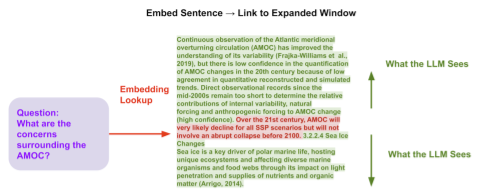

### Experiment configs

In [28]:
BASE_MODEL = 'thenlper/gte-base'  
WINDOW_SIZE = 3
TOP_K = 20

TEST_SUBSAMPLE_N = 10

EXPERIMENT_NAME = 'sentence_window'

### Load data

In [29]:
from pathlib import Path

DATASETS_DIRECTORY = Path("/efs/shared_storage/simon/datasets")

In [30]:
import json
from llama_index.schema import Document

def read_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def to_doc(entry_dict):
    return Document(text=entry_dict['text'], metadata={'source': entry_dict['source']}) 

def load_corpus(filename):
    sections = read_json(filename)
    docs = [to_doc(dict_) for dict_ in sections]
    return docs

In [32]:
docs = load_corpus(DATASETS_DIRECTORY / 'eval_full_corpus.json')

### Build index and configure query engine

In [87]:
from langchain.embeddings import HuggingFaceEmbeddings
from llama_index import ServiceContext, set_global_service_context, VectorStoreIndex
from llama_index.llms import OpenAI
from llama_index.node_parser import SentenceWindowNodeParser
from llama_index.indices.postprocessor import MetadataReplacementPostProcessor

# create the sentence window node parser
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=WINDOW_SIZE,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)

service_context = ServiceContext.from_defaults(
    embed_model=HuggingFaceEmbeddings(
        model_name=BASE_MODEL
    ),
    node_parser=node_parser,
)

index = VectorStoreIndex.from_documents(
    docs, 
    service_context=service_context, 
    show_progress=True
)

Parsing documents into nodes:   0%|          | 0/8944 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/59755 [00:00<?, ?it/s]

In [88]:
retriever = index.as_retriever(similarity_top_k=TOP_K)

In [89]:
query_engine = index.as_query_engine(
    similarity_top_k=TOP_K,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ],
)

### Run evaluation

In [90]:
import json
import numpy as np

from eval import evaluate_e2e, evaluate_retrieval

#### Retrieval-only

In [44]:
golden_dataset_path = Path("../datasets/eval-dataset-v1.jsonl")
with open(golden_dataset_path, "r") as f:
    golden_dataset = [json.loads(item) for item in list(f)]

queries = [item['question'] for item in golden_dataset]
golden_sources = [item['source'] for item in golden_dataset]

In [91]:
results = evaluate_retrieval(retriever, queries, golden_sources)

100%|██████████| 177/177 [06:18<00:00,  2.14s/it]


In [92]:
hit_rate = get_hit_rate(results)
hit_rate

0.632768361581921

#### End-to-end

In [93]:
with open("../datasets/golden-responses.json", "r") as file:
    golden_dataset = json.load(file)

queries = [item['question'] for item in golden_dataset]
golden_response = [item['response'] for item in golden_dataset]

In [94]:
results = evaluate_e2e(query_engine, queries, golden_response, verbose=True)

Running inference


100%|██████████| 10/10 [02:16<00:00, 13.61s/it]


Running eval


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


In [96]:
mean_score = get_mean_score(results)
mean_score

4.2

## Strategy 4: Fine-tune embeddings

In this section, we explore fine-tuning embedding model to improve retrieval performance.
We consider the "cold start" regime, where we haven't deployed the model, and haven't collected any user queries or labeled "golden" context. 

Therefore, we consider a synthetic data approach, where we leverage LLM to generation question, relevant context, answer pairs from our knowledge corpus.

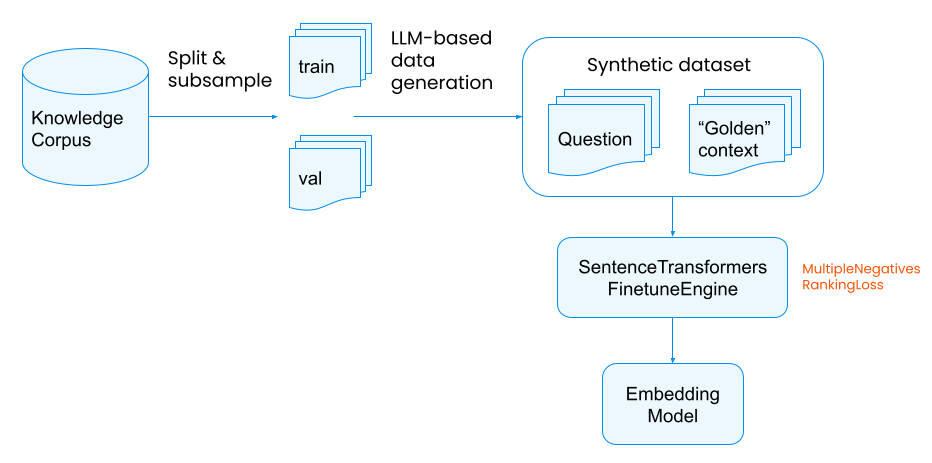

### Experiment configs

In [ ]:
import os

# Since we are working with a relatively large set of documents, 
# we sub-sample the data for quicker iterations.
SUBSAMPLE_RATIO = 0.05

# can be any sentence-transformer compatible model
# https://www.sbert.net/docs/pretrained_models.html
BASE_MODEL = 'thenlper/gte-base'  

# Select a chunk size that is: 
# 1) under the context window limit of the chosen model, and
# 2) close to the desired chunk size at retrieval time
FINETUNE_CHUNK_SIZE = 512


ROOT_DIR = Path(os.getcwd()).parent
print(ROOT_DIR)

### Load data

We start by loading our knowledge corpus (i.e. the ray documentation webpages that we've downloaded and parsed previously).

In [63]:
from pathlib import Path

DATASETS_DIRECTORY = Path("/efs/shared_storage/simon/datasets")

In [64]:
import json
from llama_index.schema import Document

def read_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def to_doc(entry_dict):
    return Document(text=entry_dict['text'], metadata={'source': entry_dict['source']}) 

def load_corpus(filename):
    sections = read_json(filename)
    docs = [to_doc(dict_) for dict_ in sections]
    return docs

In [65]:
docs = load_corpus(DATASETS_DIRECTORY / 'eval_full_corpus.json')

Now, we split the documents into chunks. The main considerations on the chunk size here are:
1. need to fit into the context window of the embedding model that we want to finetune (512 for the sentence transformer model that we selected, similar to most open source models.)
2. should be close to the chunk size we want to use at retrieval time (so it's best to run some experiments to determine the best chunk size for your application first, see strategy 1). 

In [ ]:
from llama_index.node_parser import SimpleNodeParser

parser = SimpleNodeParser.from_defaults(chunk_size=FINETUNE_CHUNK_SIZE)
nodes = parser.get_nodes_from_documents(docs, show_progress=True)
print('Parsed {} docs into {} nodes'.format(len(docs), len(nodes)))

### Subsample and create train/validation split

In [67]:
from utils import train_test_split, subsample

In [68]:
train_nodes, val_nodes = train_test_split(nodes)
print('Split dataset into: {} train nodes, {} val nodes'.format(len(train_nodes), len(val_nodes)))

Split dataset into: 11665 train nodes, 2917 val nodes


In [69]:
train_nodes = subsample(train_nodes, SUBSAMPLE_RATIO)
val_nodes = subsample(val_nodes, SUBSAMPLE_RATIO)
print('Subsampled dataset into: {} train nodes, {} val nodes'.format(len(train_nodes), len(val_nodes)))

Subsampled dataset into: 583 train nodes, 145 val nodes


### Generate synthetic dataset

Now, we will generate a synthetic dataset of question, "golden" context, and "golden" answer dataset by leveraing an LLM (by default using gpt-3.5-turbo from OpenAI)

In [ ]:
from llama_index.finetuning import generate_qa_embedding_pairs

train_dataset = generate_qa_embedding_pairs(train_nodes)
val_dataset = generate_qa_embedding_pairs(val_nodes)

Let's save the dataset for future use since it's fairly time consuming to generate.

In [ ]:
train_dataset.save_json(Path(ROOT_DIR, "finetune/synthetic_train_dataset.json"))
val_dataset.save_json(Path(ROOT_DIR, "finetune/synthetic_val_dataset.json"))

### Run embedding finetuning

Now, we are ready to fine-tune our embedding model!

In [70]:
from llama_index.finetuning import EmbeddingQAFinetuneDataset

In [71]:
train_dataset = EmbeddingQAFinetuneDataset.from_json(Path(ROOT_DIR, "finetune/synthetic_train_dataset.json"))
val_dataset = EmbeddingQAFinetuneDataset.from_json(Path(ROOT_DIR, "finetune/synthetic_val_dataset.json"))

We can construct a fine-tune engine, which is an easy to use interface for running fine-tuning jobs (either locally or via a API-based service).

Here, we use the sentence transformer fine-tuning engine to run fine-tuning locally on the ray cluster.

In [73]:
from llama_index.finetuning import SentenceTransformersFinetuneEngine

finetune_engine = SentenceTransformersFinetuneEngine(
    train_dataset,
    model_id=BASE_MODEL,
    model_output_path="../finetune/exp_finetune_test",
    val_dataset=val_dataset,
    epochs=1,
)

For demonstration purpose, we will run the fine-tuning job for 2 epoches over our synthetic dataset.
In practice, you should use the validation loss to determine how many epochs to fine-tune the embedding model for.

In [ ]:
finetune_engine.finetune()

After the fine-tuning job finishes, we can easy get a referene to the fine-tuned model to be used in our LlamaIndex application.

In [74]:
embed_model = finetune_engine.get_finetuned_model()

### Evaluate our fine-tuned embedding model

Now, we will leverage the retrieval evaluation process we built out in [part 2](www.google.com) to assess the quality of our fine-tuned embedding model.

In [ ]:
import re
import json
from pathlib import Path

# Load labeled eval dataset
golden_dataset_path = Path("../datasets/eval-dataset-v1.jsonl")

with open(golden_dataset_path, "r") as f:
    test_dataset = [json.loads(item) for item in list(f)]
    
len(test_dataset)

In [ ]:
test_dataset[:5]

In [77]:
queries = [item['question'] for item in test_dataset]
golden_sources = [item['source'] for item in test_dataset]

Now, we can build index with our fine-tuned embedding.

In [78]:
from llama_index import VectorStoreIndex, ServiceContext

In [ ]:
service_context = ServiceContext.from_defaults(
    embed_model=embed_model,
    chunk_size=512,
)

index = VectorStoreIndex.from_documents(
    docs, 
    service_context=service_context, 
    show_progress=True
)

In [80]:
retriever = index.as_retriever(similarity_top_k=5)

### Run retrieval evaluation 

In [ ]:
from eval import evaluate_retrieval

results = evaluate_retrieval(retriever, queries, golden_sources)

In [ ]:
hit_rate = get_hit_rate(results)
hit_rate

In [ ]:
average_score = sum(result["score"] for result in results) / len(results)
average_score